# This notebook explores the uncertainty from folding a known exponential spectra through the MagEIS geometric factors with uncertainty

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate
import scipy.interpolate
sns.set(font_scale=1.5)
%matplotlib inline
import sys

sys.path.append('../utils/')
import mageis_response

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/packages2/.packages2/x86_64-pc-linux-gnu-rhel7/python/3.6.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Create a true exponential spectra with E0t and J0t parameters. Then use that spectra and fold it through the MagEIS response functions to get the true counts.

In [2]:
# Spectra parameters
E0t = 100 # keV
J0t = 1E4 # 1/(cm^2 sr s keV)

# Initialize the response function
R = mageis_response.R_iso(101) # RBSP-A MagEIS LOW.
E = R.E*1000 # Energy array in keV.
FEDU_energy = [ 15.,  20.,  33.,  54.,  80., 108., 143., 184., 226.] # keV
n_ch = (1, 9) # Channels to use (1 through 9 are the main rate channels.)

# Interpolate the response functions so we can easily add uncertainty to them
# G is a function of energy that returns G(E) for all energy channels.
G = scipy.interpolate.interp1d(E, [R.response(i) for i in range(*n_ch)], axis=1)

# Define an exponential spectra.
def spectra(Earr, J0, E0):
    return(J0*np.exp(-Earr/E0))

# Now create the "true" counts drawn from the parent distribution. This assumes there
# is no uncertanity.
true_lambda = np.nan*np.zeros(n_ch[1]-n_ch[0])
for i in range(*n_ch):
    true_lambda[i-n_ch[0]] = scipy.integrate.trapz(spectra(E, J0t, E0t)*R.response(i), x=E)

Since pymc3 does not natively do integrationm, now I code in my own trapezium integrator and check against the above values (to make it compatable with pymc3).

In [3]:
plt.plot(E, spectra(E, J0t, E0t)); plt.title('True exponential spectra')
plt.yscale('log'); plt.xlabel('Energy (keV)'); plt.ylabel('Flux'); 
plt.tight_layout(); plt.savefig('true_exp_spectra.png', dpi=300)

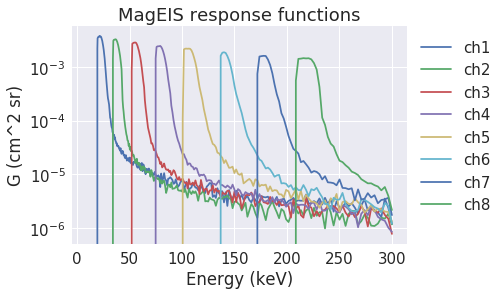

In [4]:
for i in range(*n_ch):
    plt.plot(E, R.response(i), label='ch{}'.format(i));
plt.xlabel('Energy (keV)'); plt.ylabel('G (cm^2 sr)'); 
plt.title('MagEIS response functions'); plt.yscale('log');
plt.legend(bbox_to_anchor=(1, 1)); #plt.savefig('response.png', dpi=300)

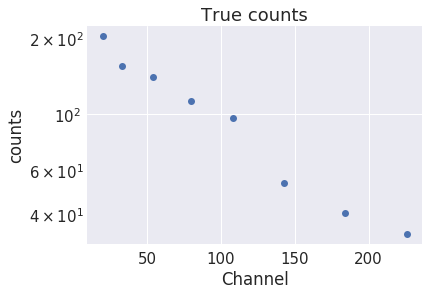

In [5]:
plt.semilogy(FEDU_energy[n_ch[0]:n_ch[1]], true_lambda, 'o'); 
plt.ylabel('counts'); plt.xlabel('Channel'); plt.title('True counts');

Now add realism by drawing observed counts from true_lambda assuming a Poisson process

In [6]:
np.random.seed(123)
c_obs = np.random.poisson(true_lambda)

Visualize the counts derived from the spectra without uncertainty, and the counts that could have been observed if we assume a poisson process

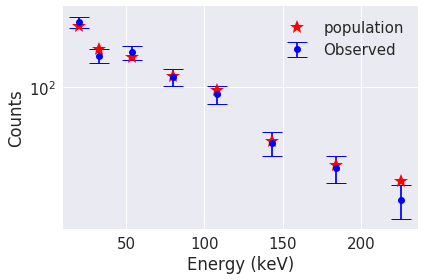

In [7]:
(_, caps, _) = plt.errorbar(FEDU_energy[n_ch[0]:n_ch[1]], c_obs, yerr=np.sqrt(c_obs), c='b', fmt='o', 
                            label='Observed', capsize=10)
for cap in caps:
    cap.set_markeredgewidth(1)
plt.plot(FEDU_energy[n_ch[0]:n_ch[1]], true_lambda, 'r*', ms=15, 
         label=r'population')
plt.yscale('log'); plt.legend(); plt.ylabel('Counts'); plt.xlabel('Energy (keV)');
plt.tight_layout(); plt.savefig('compare_true_counts.png', dpi=300)

### Bayes model
Here we explore how to back out the exponential spectra from the observed counts. We work with informed and uninformed spectral parameter priors (switch below) and add uncertnaity to the response functions (scale up/down, move left/right).

In [8]:
def getPriors(informedSpecP, Roffset, Eoffset):
    """
    
    """
    if informedSpecP:
        BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
        J0 = BoundedNormal('J0', mu=1E4, sd=1E5)
        E0 = BoundedNormal('E0', mu=100, sd=500)
    else:
        J0 = pm.Uniform('J0', lower=0, upper=1E7)
        E0 = pm.Uniform('E0', lower=0, upper=500)
    
    # G(E) modifications
    if Roffset:
        Roff = pm.Normal('Roff', mu=1, 
                         sd=Roffset/(100*2*np.sqrt(2*np.log(2))), 
                         shape=len(c_obs))
    else:
        Roff = np.ones_like(c_obs)
    if Eoffset:
        Eoff = pm.Normal('Eoff', mu=1, 
                         sd=Eoffset/(100*2*np.sqrt(2*np.log(2))), 
                         shape=len(c_obs))
    else:
        Eoff = np.zeros_like(c_obs)
    return J0, E0, Roff, Eoff

In [9]:
informedPrior = True # use uniform or normal priors on J0 and E0.
# This sets the R(E) scale to unity or normally distributed.
# If False, will not modify the response functions.
Roffset = 10        # R(E) fwhm amplitude offset (percent)
Eoffset = 10        # This keyword sets the energy offset (percent)


def pymcTrapz(f, x):
    """
    This function is the pymc3 Trapz implementation for an uneven grid.
    It integrates a function f over an uneven grid x.
    """
    return 0.5*pm.math.dot((f[1:] + f[:-1]), (x[1:] - x[:-1]))

def lam(JJ, Roffset, Eoffset):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the instrument response functions.
    My implementation of trapezium is not the fastest, but it will do.
    """
    lams = len(c_obs)*[None]
    
    for i in range(len(c_obs)):
        #f is chanel-dependent offset * flux arr * interpolated 
        # G(E * a random energy offset)
        f = Roffset[i]*JJ*G(E)[i]  #G(E*Eoffset[i])[i] 
        lams[i] = pm.Deterministic('lam{}'.format(i), pymcTrapz(f, E))
    return lams

m = pm.Model()
with m:
    # Prior stocastic variables
    J0, E0, Roff, Eoff = getPriors(informedPrior, Roffset, Eoffset)
    
    # Define an exponential spectra
    J = J0*pm.math.exp(-E/E0)
    
    lams = lam(J, Roff, Eoff)
    c_m = pm.Poisson('c_m', mu=lams, observed=c_obs, shape=len(c_obs))
    trace = pm.sample(1E4, tuning=1000, cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [Eoff, Roff, E0_lowerbound__, J0_lowerbound__]
  7%|▋         | 724/10500.0 [00:09<02:09, 75.34it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '14809' (I am process '14810')
  7%|▋         | 757/10500.0 [00:09<02:05, 77.89it/s]INFO (theano.gof.compilelock): To manually release the lock, delete /home/msshumko/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-redhat-7.5-Maipo-x86_64-3.6.0-64/lock_dir
100%|██████████| 10500/10500.0 [00:38<00:00, 273.65it/s]


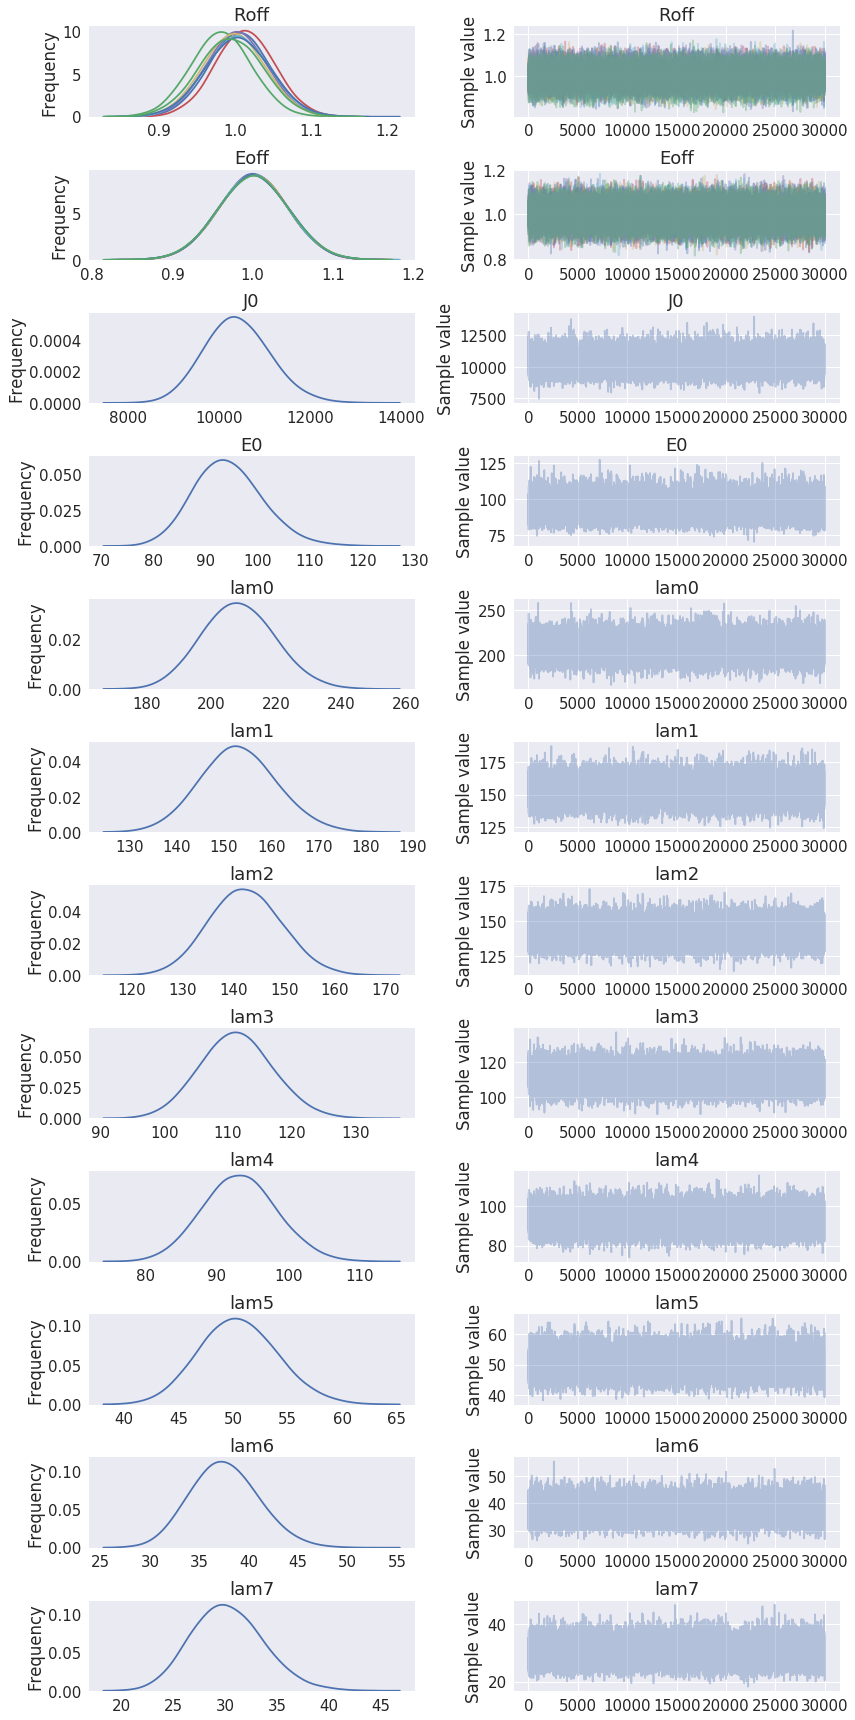

In [10]:
pm.traceplot(trace, combined=True);

In [11]:
pm.summary(trace)

mean          sd  mc_error      hpd_2.5      hpd_97.5  \
Roff__0      1.005266    0.039425  0.000211     0.928491      1.083292   
Roff__1      0.981542    0.039305  0.000204     0.906654      1.059693   
Roff__2      1.012565    0.038465  0.000164     0.937668      1.089457   
Roff__3      1.001693    0.039238  0.000197     0.924491      1.078006   
Roff__4      0.998366    0.039910  0.000216     0.921192      1.077241   
Roff__5      1.002968    0.041378  0.000203     0.922833      1.085212   
Roff__6      1.002774    0.041734  0.000181     0.920763      1.084539   
Roff__7      0.994347    0.041830  0.000221     0.910740      1.075226   
Eoff__0      0.999954    0.042333  0.000218     0.918053      1.083802   
Eoff__1      1.000070    0.042710  0.000230     0.917063      1.084313   
Eoff__2      1.000373    0.042293  0.000172     0.919744      1.084597   
Eoff__3      0.999897    0.042174  0.000188     0.917768      1.082547   
Eoff__4      1.000215    0.042491  0.000222     0.917619      1.084698   
Eoff__5      0.999954    0.042378  0.000201     0.916862      1.083183   
Eoff__6      1.000292    0.042587  0.000189     0.918301      1.083926   
Eoff__7      1.000193    0.042779  0.000210     0.916845      1.084151   
J0       10390.984988  709.512414  4.687391  9026.042928  11796.133766   
E0          94.299913    6.550853  0.044605    81.760588    107.268044   
lam0       208.256968   11.195525  0.054618   186.826000    230.410762   
lam1       153.001461    8.125230  0.043093   137.092961    169.027115   
lam2       142.245664    7.097366  0.038727   128.818106    156.512685   
lam3       111.301724    5.653034  0.027674   100.059480    122.138401   
lam4        93.160842    5.163337  0.027975    83.196264    103.341921   
lam5        50.455931    3.594244  0.020713    43.769590     57.814576   
lam6        37.514566    3.421117  0.019740    30.963753     44.268451   
lam7        30.165410    3.444550  0.020270    23.627585     36.977910   

                n_eff      Rhat  
Roff__0  37259.840104  0.999981  
Roff__1  34261.355618  0.999954  
Roff__2  44000.643126  0.999988  
Roff__3  48115.082051  0.999959  
Roff__4  28936.892965  1.000011  
Roff__5  42449.808284  0.999977  
Roff__6  45429.028941  0.999995  
Roff__7  40276.622668  0.999957  
Eoff__0  42682.200124  1.000114  
Eoff__1  43686.702491  0.999960  
Eoff__2  50985.387779  0.999974  
Eoff__3  42744.145357  1.000007  
Eoff__4  45374.951053  1.000025  
Eoff__5  48514.924580  1.000024  
Eoff__6  45266.255500  0.999962  
Eoff__7  43382.421581  0.999983  
J0       19703.676467  0.999958  
E0       20692.204215  0.999971  
lam0     33495.027360  0.999984  
lam1     33134.339129  0.999959  
lam2     32723.929839  0.999960  
lam3     34973.889942  0.999957  
lam4     30849.271454  0.999989  
lam5     32398.745266  0.999981  
lam6     29607.069170  0.999954  
lam7     26262.943735  0.999961

In [12]:
c_mean = [np.mean(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
c_std = [np.std(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
c_ci = np.asarray([np.percentile(trace['lam{}'.format(i)], (2.5, 97.5)) 
                    for i in range(len(c_obs))])

In [13]:
(_, caps, _) = plt.errorbar(range(len(c_obs)), c_mean, yerr=np.sqrt(c_mean), 
                            c='r', fmt='o', capsize=10, label='Modeled counts'); 
for cap in caps:
    cap.set_markeredgewidth(1)
plt.plot(range(len(c_obs)), c_obs, 'bo', label='Observed counts'); 
plt.legend();

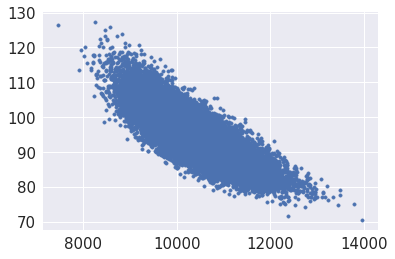

In [14]:
plt.scatter(trace['J0'], trace['E0'], marker='.');

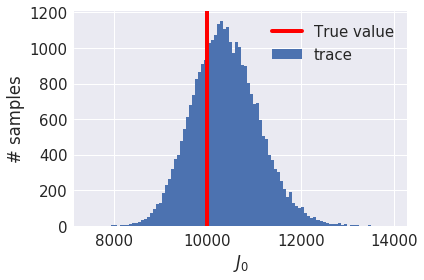

In [29]:
plt.hist(trace['J0'], bins=100, label='trace')
plt.axvline(J0t, c='r', lw=4, label='True value');
plt.legend(); plt.xlabel(r'$J_0$'); plt.ylabel('# samples');
plt.tight_layout(); 
plt.savefig('J0_trace_hist.png', dpi=300)

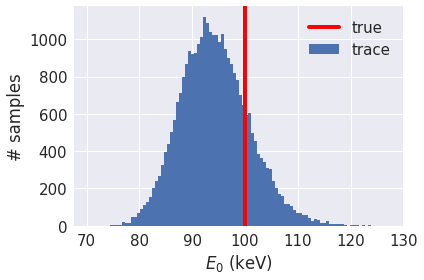

In [16]:
plt.hist(trace['E0'], bins=100, label='trace');
plt.axvline(E0t, c='r', lw=4, label='true');
plt.legend(); plt.xlabel(r'$E_0$ (keV)'); plt.ylabel('# samples');
plt.tight_layout(); 
plt.savefig('E0_trace_hist.png', dpi=300)

## Posterior post predictive checks
Here we draw samples from the posterior distribution and check if the calculated counts from the picked E0 and J0 values are consistant with the data. Essentialy, we are looking to see if the observed counts are inside the drawn posterior distribution. 

In [17]:
ppc = pm.sample_ppc(trace, samples=2000, model=m)

100%|██████████| 2000/2000 [00:01<00:00, 1042.83it/s]


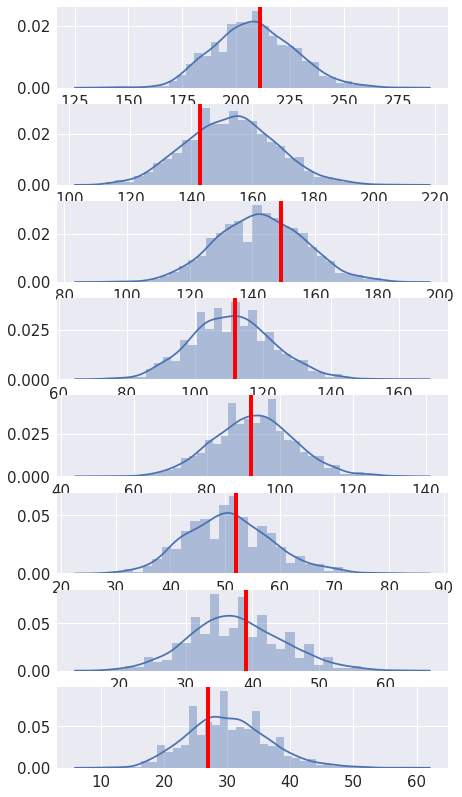

In [18]:
fig, ax = plt.subplots(len(c_obs),1, figsize=(7,14))
for i in range(len(c_obs)):
    sns.distplot(ppc['c_m'][:,i], ax=ax[i])
    ax[i].axvline(c_obs[i], c='r', lw=4)

## Statistics of the J0 and E0 distributions that are consistant with the observed counts 
Now we calculate the statistics of 100 spectra drawn from the trace (mean, median, 2.5%, and 95% credible interval) as a function of energy

Pick 100 random draws of E0 and J0 from the trace, and calculate the statistics on those draws as a function of energy.

In [26]:
nS = 100
random_samples = np.random.randint(0, len(trace), nS)
# Old code
# dist = np.zeros((len(E), nS), dtype=float)
# for (i, s) in enumerate(random_samples):
#     for e in range(len(E)):
#         dist[e, i] = spectra(E, trace['J0'][s], trace['E0'][s])[e]

# New code that is much more efficient (and is the valid way to calculate CI).
# Now combine all of the spectra
fSpec = np.array([spectra(E, Ji, Ei) 
                  for Ji, Ei in zip(trace['J0'], trace['E0'])]).T
dist = fSpec[:, random_samples]

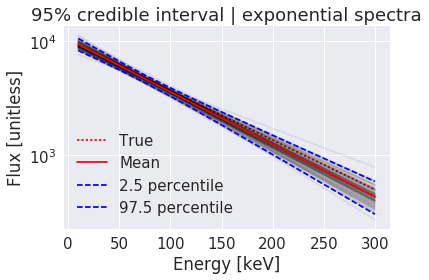

In [38]:
plt.plot(E, spectra(E, J0t, E0t), 'r:', label='True')
for i in random_samples:
    plt.plot(E, spectra(E, trace['J0'][i], trace['E0'][i]), c='k', alpha=0.07)
plt.plot(E, np.mean(fSpec, axis=1), 'r', label='Mean');
plt.plot(E, np.percentile(fSpec, 2.5, axis=1), 'b--', label='2.5 percentile')
plt.plot(E, np.percentile(fSpec, 97.5, axis=1), 'b--', label='97.5 percentile')
plt.legend(); plt.yscale('log'); plt.ylabel('Flux [unitless]');
plt.xlabel('Energy [keV]'); plt.title('95% credible interval | exponential spectra');
plt.tight_layout(); plt.savefig('exp_spec_range_count_stats.png', dpi=300)

Calculate the credible intervals for E0 and J0

In [ ]:
J0_ci = np.percentile(trace['J0'], (2.5, 97.5)); 
E0_ci = np.percentile(trace['E0'], (2.5, 97.5));

print('J0_ci = {}, E0_ci = {}'.format(J0_ci, E0_ci))